In [3]:
# Making Necessary Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from math import sqrt, log, exp, pi
import seaborn as sns
import pickle

In [4]:
# Importing the dataset

galaxies = pd.read_csv("galaxies.csv")

In [5]:
galaxies['x'] = galaxies['x']/1000

In [6]:
velocities = galaxies['x']

(array([0.06071575, 0.0242863 , 0.        , 0.        , 0.        ,
        0.        , 0.0242863 , 0.        , 0.        , 0.0728589 ,
        0.25500613, 0.10928834, 0.08500204, 0.12143149, 0.10928834,
        0.06071575, 0.01214315, 0.0242863 , 0.        , 0.        ,
        0.        , 0.        , 0.01214315, 0.01214315, 0.01214315]),
 array([ 9.172  , 10.17628, 11.18056, 12.18484, 13.18912, 14.1934 ,
        15.19768, 16.20196, 17.20624, 18.21052, 19.2148 , 20.21908,
        21.22336, 22.22764, 23.23192, 24.2362 , 25.24048, 26.24476,
        27.24904, 28.25332, 29.2576 , 30.26188, 31.26616, 32.27044,
        33.27472, 34.279  ]),
 <BarContainer object of 25 artists>)

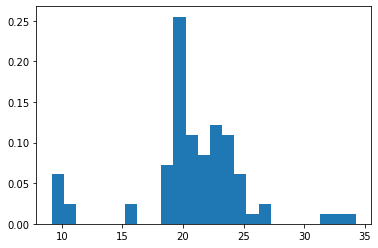

In [7]:
plt.hist(velocities, bins = 25, density=True)

In [8]:
# Function to calculate pi_i_k

def calculate_pi_ik(data, pi_vals, mu_k, sigma, K):
    pi_i_k = np.zeros((len(data), K))
    for i in range(len(data)):
        for k in range(K):
            numerator = pi_vals[k]*norm.pdf(data[i], mu_k[k], sigma)
            denominator = 0
            for j in range(K):
                denominator = denominator + pi_vals[j]*norm.pdf(data[i], mu_k[j], sigma)
            pi_i_k[i][k] = numerator/denominator
    return pi_i_k

In [9]:
#Calculate the density corresponding to each datapoint

def calculate_ys(data, pi_vals, mu_k, sigma, K):
    ys = []
    for i in range(len(data)):
        sum = 0
        for k in range(K):
            sum = sum + pi_vals[k]*norm.pdf(data[i], mu_k[k], sigma)
        ys.append(sum)
    return ys

In [10]:
# Calculate the Likelihood Q value.

def calculate_q(data, pi_vals, mu_k, sigma, K):
    pi_i_k = calculate_pi_ik(data, pi_vals, mu_k, sigma, K)
    sum = 0
    for i in range(len(data)):
        for k in range(K):
            sum = sum + pi_i_k[i][k]*(-0.5*log(sigma**2) - ((data[i] - mu_k[k])**2)/(2*sigma**2) + log(pi_vals[k]))
    return sum 

In [11]:
# Function to update the pi_k value

def update_pi_k(data, pi_vals, mu_k, sigma, K):
    pi_k_new = []
    pi_i_k = calculate_pi_ik(data, pi_vals, mu_k, sigma, K)
    for k in range(K):
        numerator = 0
        for i in range(len(data)):
            numerator = numerator + pi_i_k[i][k]
        denominator = 0
        for j in range(K):
            for i in range(len(data)):
                denominator = denominator + pi_i_k[i][j]
        pi_k_new.append(numerator/denominator)

    return pi_k_new

In [12]:
# Function to update the mu_k value

def update_mu_k(data, pi_vals, mu_k, sigma, K):
    mu_k_new = []
    pi_i_k = calculate_pi_ik(data, pi_vals, mu_k, sigma, K)
    for k in range(K):
        numerator = 0
        for i in range(len(data)):
            numerator = numerator + pi_i_k[i][k]*data[i]
        denominator = 0
        for i in range(len(data)):
            denominator = denominator + pi_i_k[i][k]
        mu_k_new.append(numerator/denominator)
    return mu_k_new


In [13]:
# Function to update the sigma value

def update_sigma(data, pi_vals, mu_k, sigma, K):
    sigma_new = 0
    pi_i_k = calculate_pi_ik(data, pi_vals, mu_k, sigma, K)
    for i in range(len(data)):
        for k in range(K):
            sigma_new = sigma_new + ((pi_i_k[i][k]/len(data))*(data[i] - mu_k[k])**2)
    return sigma_new

In [14]:
# EM Algorithm implementation

def em_algorithm(data, K):
    
    # Initializing random values for the parameters
    pi_old = [np.random.uniform(0, 1) for _ in range(K)]
    pi_old = np.asarray(pi_old)
    pi_old = pi_old/np.sum(pi_old)
    pi_old = pi_old.tolist()

    mu_old = [np.random.uniform(0, 30) for _ in range(K)]
    sigma_old = np.random.uniform(0, 100)

    q_old = calculate_q(data, pi_old, mu_old, pow(sigma_old, 0.5), K)
    q_new = 0
    pi_new = 0
    mu_new = 0
    sigma_new = 0

    count = 0

    # E step
    while(abs(q_new - q_old) >= 10e-4):

        # M Step
        if(count <= 20):
            pi_new = update_pi_k(data, pi_old, mu_old, pow(sigma_old, 0.5), K)
            mu_new = mu_old
            sigma_new = update_sigma(data, pi_new, mu_new, pow(sigma_old, 0.5), K)
        else:
            pi_new = update_pi_k(data, pi_old, mu_old, pow(sigma_old, 0.5), K)
            mu_new = update_mu_k(data, pi_new, mu_old, pow(sigma_old, 0.5), K)
            sigma_new = update_sigma(data, pi_new, mu_new, pow(sigma_old, 0.5), K)

        q_old = q_new
        q_new = calculate_q(data, pi_new, mu_new, pow(sigma_new, 0.5), K)

        pi_old = pi_new
        sigma_old = sigma_new
        mu_old = mu_new

        count += 1
        if(count % 10 == 0):
            print("Iteration " + str(count) + ": q_new = " + str(q_new))

    return pi_new, mu_new, pow(sigma_new, 0.5)

In [15]:
# Function to calculate all the parameters one-shot
def calculate_parameters(data):
    parameters = []
    k_vals = [4,6,8,11,15,20]
    for k in k_vals:
        parameters.append(em_algorithm(data, k))
    return parameters

In [16]:
# Function to plot the values one-shot

def calculate_vals_for_plot(data, values):
    k_vals = [4,6,8,11,15,20]
    new_ys_k = []
    for k,value in zip(k_vals, values):
        new_ys_k.append(calculate_ys(data, value[0], value[1], value[2], k))
    return new_ys_k

def plotter(new_ys_k, data):

    fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (15,15))
    x_values = np.linspace(start = 0, stop = 35, num = 1000)
    
    ax[0,0].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[0,0].plot(x_values, new_ys_k[0], label = 'Fitted curve')
    ax[0,0].set_title('Fitted Normal Location Mixture Model with K = 4')
    ax[0,0].set_xlabel('Velocities')
    ax[0,0].set_ylabel('Density')
    ax[0,0].legend(loc = 'upper right')

    ax[0,1].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[0,1].plot(x_values, new_ys_k[1], label = 'Fitted curve')
    ax[0,1].set_title('Fitted Normal Location Mixture Model with K = 6')
    ax[0,1].set_xlabel('Velocities')
    ax[0,1].set_ylabel('Density')
    ax[0,1].legend(loc = 'upper right')

    ax[1,0].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[1,0].plot(x_values, new_ys_k[2], label = 'Fitted curve')
    ax[1,0].set_title('Fitted Normal Location Mixture Model with K = 8')
    ax[1,0].set_xlabel('Velocities')
    ax[1,0].set_ylabel('Density')
    ax[1,0].legend(loc = 'upper right')

    ax[1,1].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[1,1].plot(x_values, new_ys_k[3], label = 'Fitted curve')
    ax[1,1].set_title('Fitted Normal Location Mixture Model with K = 11')
    ax[1,1].set_xlabel('Velocities')
    ax[1,1].set_ylabel('Density')
    ax[1,1].legend(loc = 'upper right')

    ax[2,0].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[2,0].plot(x_values, new_ys_k[4], label = 'Fitted curve')
    ax[2,0].set_title('Fitted Normal Location Mixture Model with K = 15')
    ax[2,0].set_xlabel('Velocities')
    ax[2,0].set_ylabel('Density')
    ax[2,0].legend(loc = 'upper right')

    ax[2,1].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[2,1].plot(x_values, new_ys_k[5], label = 'Fitted curve')
    ax[2,1].set_title('Fitted Normal Location Mixture Model with K = 20')
    ax[2,1].set_xlabel('Velocities')
    ax[2,1].set_ylabel('Density')
    ax[2,1].legend(loc = 'upper right')

In [99]:
# Calculating all parameters
arameters = calculate_parameters(velocities)

Iteration 10: q_new = -172.391525944102
Iteration 10: q_new = -211.50099373967237
Iteration 20: q_new = -207.49169412902347
Iteration 30: q_new = -161.78340521143556
Iteration 10: q_new = -242.88542095576415
Iteration 20: q_new = -243.99169457252927
Iteration 30: q_new = -221.1198817634456
Iteration 10: q_new = -240.07286391297578
Iteration 20: q_new = -224.06592818026328
Iteration 30: q_new = -211.40525573575897
Iteration 40: q_new = -153.9479822412161
Iteration 50: q_new = -157.0511778777921
Iteration 60: q_new = -151.17974473726412
Iteration 70: q_new = -150.5425406966394
Iteration 10: q_new = -275.4893827231184
Iteration 20: q_new = -272.12968799519894
Iteration 30: q_new = -242.79241915949385
Iteration 40: q_new = -226.894091157289
Iteration 50: q_new = -174.1639614598281
Iteration 60: q_new = -170.25413002270727
Iteration 70: q_new = -167.4235512079319
Iteration 80: q_new = -164.6649685712919
Iteration 90: q_new = -163.75275967654008
Iteration 10: q_new = -261.58339210604913
Iter

In [109]:
# Saving the parameters for future use. 
with open('updated_parameters.pickle', 'wb') as file:
    pickle.dump(parameters, file)

In [17]:
parameters2 = None
with open('updated_parameters.pickle', 'rb') as file:
    parameters2 = pickle.load(file)

In [18]:
# Calculating the corresponding densities using the newly obtained parameters for our new samples.

x_values = np.linspace(start = 0, stop = 35, num = 1000)
new_y_values = calculate_vals_for_plot(x_values, parameters2)

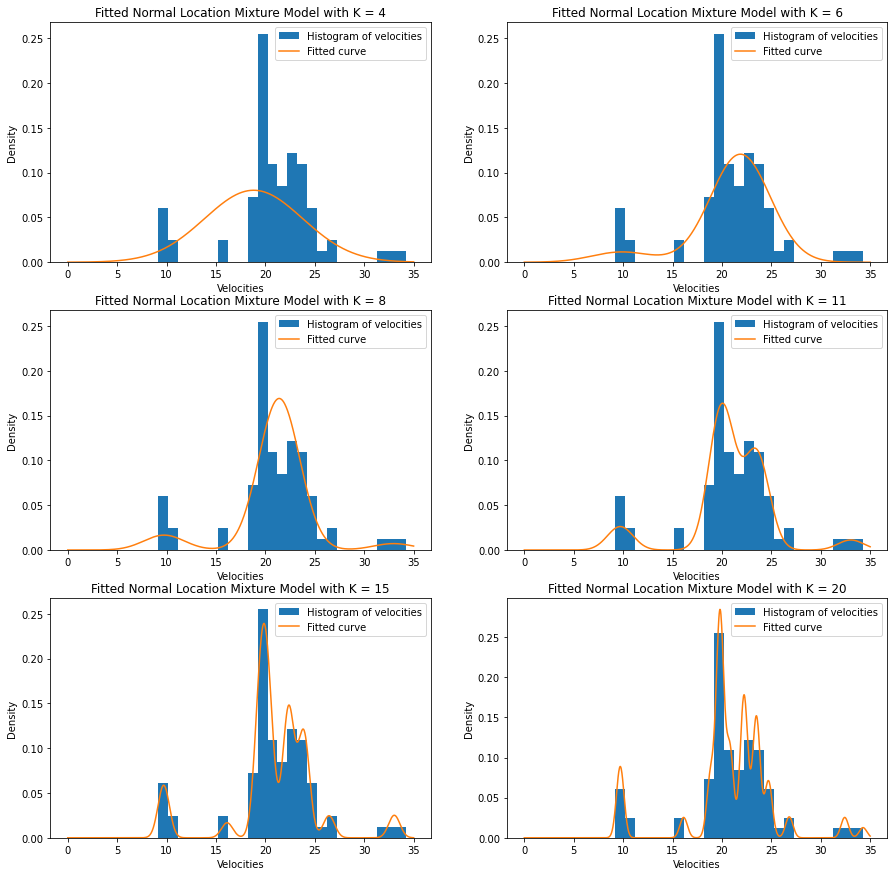

In [19]:
# Plots of fitted curves vs actual distribution.

plotter(new_y_values, velocities)

In [24]:
# Function to calculate AIC

def calculate_aic(data, parameters):
    aic_k = []
    k_vals = [4,6,8,11,15,20]
    k_indicator = 0 
    for param in parameters:
        vals =  2*(-1*calculate_q(data, param[0], param[1], param[2], k_vals[k_indicator]) + k_vals[k_indicator])
        aic_k.append(vals)
        k_indicator +=1    
    return aic_k

In [25]:
aic_k = calculate_aic(velocities, parameters2)

In [26]:
aic_k

[352.7817689704255,
 335.5590562953825,
 380.22546857572144,
 323.0554458958644,
 357.3091456396654,
 314.15244074768043]

In [29]:
# Function to calculate BIC

def calculate_bic(data, parameters):
    bic_k = []
    k_vals = [4,6,8,11,15,20]
    k_indicator = 0 
    for param in parameters:
        vals =  -2*calculate_q(data, param[0], param[1], param[2], k_vals[k_indicator]) + k_vals[k_indicator]*log(len(data))
        bic_k.append(vals)
        k_indicator +=1    
    return bic_k

In [31]:
bic_k = calculate_bic(velocities, parameters2)
bic_k

[362.4086459594825,
 349.999371778968,
 399.4792225538355,
 349.5293576157712,
 393.40993434862924,
 362.2868256929655]